**1**

In [ ]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, roc_curve
)
import joblib
import os
from datetime import datetime
import firebase_admin
from firebase_admin import credentials, db
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


**2**

In [ ]:
# Initialize Firebase app (you'll need to upload your Firebase credentials JSON file to Colab)
cred = credentials.Certificate("/content/drive/MyDrive/Firebase-Credentials/waterqualitymonitoring-10336-firebase-adminsdk-aj5im-2ef10d4277.json")
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://waterqualitymonitoring-10336-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

ValueError: The default Firebase app already exists. This means you called initialize_app() more than once without providing an app name as the second argument. In most cases you only need to call initialize_app() once. But if you do want to initialize multiple apps, pass a second argument to initialize_app() to give each app a unique name.

**3**

In [ ]:
def fetch_sensor_data():
    """Fetch sensor data from Firebase Realtime Database"""
    try:
        # Get reference to sensor_data
        ref = db.reference('sensor_data')

        # ALSO fetch ground truth labels if available
        labels_ref = db.reference('water_quality_labels')  # Add this

        data = ref.get()
        labels_data = labels_ref.get()  # Add this

        if not data:
            return pd.DataFrame()

        # Convert to list of dictionaries
        records = []
        for key, value in data.items():
            value['timestamp'] = datetime.strptime(value['timestamp'], '%Y-%m-%d %H:%M:%S')
            # Add ground truth label if available
            if labels_data and key in labels_data:
                value['true_quality_grade'] = labels_data[key]['grade']
            records.append(value)

        df = pd.DataFrame(records)
        df = df.sort_values('timestamp')
        return df

    except Exception as e:
        print(f"Error fetching sensor data: {e}")
        return pd.DataFrame()

**4**

In [ ]:
# Load data from Firebase and preprocess
print("Loading data from Firebase...")
df = fetch_sensor_data()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print("\nDataset head:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

print("\nBasic statistics:")
print(df.describe())

Loading data from Firebase...
Dataset shape: (22471, 6)
Date range: 2024-11-02 09:33:00 to 2025-04-26 19:04:51

Dataset head:
       conductivity       ph        tds  temperature           timestamp  \
8473      289.82853  6.97361  142.73901       6.7798 2024-11-02 09:33:00   
7849      235.89012  6.99664  107.41648       7.4540 2024-11-02 09:33:22   
10377     324.99847  7.05138  165.08363       7.2506 2024-11-02 09:33:44   
4001      283.55528  8.53877  138.18708       7.7566 2024-11-02 09:33:45   
9574      262.77725  7.05983  122.88723       7.2870 2024-11-02 09:41:03   

       turbidity  
8473     1.70666  
7849     2.03304  
10377    1.42057  
4001     4.01000  
9574     1.47834  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 22471 entries, 8473 to 12735
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   conductivity  22471 non-null  float64       
 1   ph            22471 non-nul

**5**

In [ ]:
class WaterQualityClassifier:
    def __init__(self):
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            class_weight='balanced'  # Handle class imbalance
        )
        self.scaler = MinMaxScaler()

    def get_quality_grade_realistic(self, row):
        """Determine water quality grade with realistic uncertainty but good predictability"""
        ph = row['ph']
        turbidity = row['turbidity']
        tds = row['tds']
        temperature = row['temperature']
        conductivity = row['conductivity']

        # Add small amount of realistic noise (reduced from previous version)
        ph_noise = np.random.normal(0, 0.05)  # Reduced noise
        turbidity_noise = np.random.normal(0, 0.1)  # Reduced noise
        tds_noise = np.random.normal(0, 5)  # Reduced noise

        ph += ph_noise
        turbidity += turbidity_noise
        tds += tds_noise

        # Score-based system with clearer boundaries
        grade_score = 0

        # pH scoring (weight: 25%) - clearer boundaries
        if 7.0 <= ph <= 8.0:
            grade_score += 25
        elif 6.5 <= ph <= 8.5:
            grade_score += 20
        elif 6.0 <= ph <= 9.0:
            grade_score += 12
        else:
            grade_score += 0  # Poor pH

        # Turbidity scoring (weight: 25%)
        if turbidity < 1.5:
            grade_score += 25
        elif turbidity < 3.0:
            grade_score += 20
        elif turbidity < 5.0:
            grade_score += 12
        else:
            grade_score += 0  # High turbidity

        # TDS scoring (weight: 25%)
        if tds < 350:
            grade_score += 25
        elif tds < 550:
            grade_score += 20
        elif tds < 750:
            grade_score += 12
        else:
            grade_score += 0  # High TDS

        # Temperature scoring (weight: 25%)
        if 20 <= temperature <= 28:
            grade_score += 25
        elif 15 <= temperature <= 32:
            grade_score += 20
        elif 10 <= temperature <= 35:
            grade_score += 12
        else:
            grade_score += 0  # Extreme temperature

        # Add small random variation (±3 points instead of ±5)
        grade_score += np.random.randint(-3, 4)

        # Convert to grades with realistic but limited boundary uncertainty
        if grade_score >= 90:
            return 'A' if np.random.random() > 0.05 else 'B'  # 95% confidence
        elif grade_score >= 75:
            return 'B' if np.random.random() > 0.1 else ('A' if np.random.random() > 0.7 else 'C')
        elif grade_score >= 55:
            return 'C' if np.random.random() > 0.1 else ('B' if np.random.random() > 0.8 else 'D')
        elif grade_score >= 35:
            return 'C' if np.random.random() > 0.2 else 'D'
        else:
            return 'D' if np.random.random() > 0.1 else 'C'  # 90% confidence for poor quality

    def prepare_data(self, data):
        """Prepare data for training or prediction"""
        features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']
        return data[features]

print("WaterQualityClassifier class with realistic uncertainty defined successfully!")

WaterQualityClassifier class with realistic uncertainty defined successfully!


**6**

In [ ]:
# Initialize classifier
classifier = WaterQualityClassifier()

np.random.seed(42)  # For reproducibility
df['quality_grade'] = df.apply(classifier.get_quality_grade_realistic, axis=1)

# Ensure minimum samples per class with smarter synthetic generation
min_samples_per_class = 80  # Slightly higher minimum
print("\nBalancing classes...")

for grade in ['A', 'B', 'C', 'D']:
    current_count = (df['quality_grade'] == grade).sum()
    print(f"Grade {grade}: {current_count} samples")

    if current_count < min_samples_per_class:
        grade_samples = df[df['quality_grade'] == grade].copy()
        additional_needed = min_samples_per_class - current_count

        print(f"Adding {additional_needed} synthetic samples for Grade {grade}")

        for _ in range(additional_needed):
            # Create more realistic synthetic samples
            if len(grade_samples) > 0:
                base_sample = grade_samples.sample(1).copy()

                # Add controlled noise based on parameter ranges
                for col in ['ph', 'turbidity', 'tds', 'temperature', 'conductivity']:
                    original_value = base_sample[col].iloc[0]
                    # Add 2-5% noise instead of fixed percentage
                    noise_factor = np.random.uniform(0.02, 0.05)
                    noise = np.random.normal(0, abs(original_value) * noise_factor)
                    base_sample[col] = original_value + noise

                # Ensure the synthetic sample still belongs to the same grade
                # by keeping it within reasonable bounds for that grade
                new_grade = classifier.get_quality_grade_realistic(base_sample.iloc[0])
                if new_grade == grade:  # Only add if it maintains the same grade
                    df = pd.concat([df, base_sample], ignore_index=True)

# Add temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Feature engineering - selective interaction terms
df['ph_turbidity_interaction'] = df['ph'] * df['turbidity']
df['tds_conductivity_ratio'] = df['tds'] / (df['conductivity'] + 1e-8)

# Display final class distribution
print("\nFinal Class Distribution:")
class_dist = df['quality_grade'].value_counts().sort_index()
print(class_dist)
print("\nClass Percentages:")
print((class_dist / len(df) * 100).round(2))

# Focused feature set (remove some temporal features that add noise)
features = ['ph', 'turbidity', 'tds', 'temperature', 'conductivity',
           'ph_turbidity_interaction', 'tds_conductivity_ratio']

X = df[features]
y = df['quality_grade']

# Use stratified split to ensure balanced representation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
X_train_scaled = classifier.scaler.fit_transform(X_train)
X_test_scaled = classifier.scaler.transform(X_test)

print(f"\nFinal dataset - Training: {len(X_train)}, Testing: {len(X_test)}")
print(f"Training class distribution:\n{pd.Series(y_train).value_counts().sort_index()}")
print(f"Testing class distribution:\n{pd.Series(y_test).value_counts().sort_index()}")


Balancing classes...
Grade A: 3485 samples
Grade B: 8808 samples
Grade C: 9373 samples
Grade D: 805 samples

Final Class Distribution:
quality_grade
A    3485
B    8808
C    9373
D     805
Name: count, dtype: int64

Class Percentages:
quality_grade
A    15.51
B    39.20
C    41.71
D     3.58
Name: count, dtype: float64

Final dataset - Training: 17976, Testing: 4495
Training class distribution:
quality_grade
A    2788
B    7046
C    7498
D     644
Name: count, dtype: int64
Testing class distribution:
quality_grade
A     697
B    1762
C    1875
D     161
Name: count, dtype: int64


**7**

In [ ]:
# Implement k-fold cross-validation
print("=== CROSS-VALIDATION RESULTS ===")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(classifier.model, X_train_scaled, y_train, cv=kfold, scoring='f1_macro')

print(f"CV F1-Score (Macro): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model
print("\nTraining final model...")
classifier.model.fit(X_train_scaled, y_train)
y_pred = classifier.model.predict(X_test_scaled)

# Calculate realistic metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print(f"Cross-Validation F1 (Macro): {cv_scores.mean():.4f}")

print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, zero_division=0))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': classifier.model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)

# Create metrics summary table for research paper
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)',
               'CV F1-Score (Macro)'],
    'Value': [accuracy, precision_macro, recall_macro, f1_macro,
              precision_weighted, recall_weighted, f1_weighted, cv_scores.mean()]
})
metrics_df['Value'] = metrics_df['Value'].round(4)
print("\n=== METRICS SUMMARY TABLE FOR RESEARCH PAPER ===")
print(metrics_df.to_string(index=False))

=== CROSS-VALIDATION RESULTS ===
CV F1-Score (Macro): 0.6146 (+/- 0.0191)

Training final model...
=== MODEL PERFORMANCE METRICS ===
Accuracy: 0.7898
Precision (Macro): 0.6345
Recall (Macro): 0.6339
F1-Score (Macro): 0.6338
Precision (Weighted): 0.7835
Recall (Weighted): 0.7898
F1-Score (Weighted): 0.7865
Cross-Validation F1 (Macro): 0.6146

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           A       0.83      0.84      0.83       697
           B       0.80      0.81      0.80      1762
           C       0.81      0.82      0.81      1875
           D       0.10      0.07      0.09       161

    accuracy                           0.79      4495
   macro avg       0.63      0.63      0.63      4495
weighted avg       0.78      0.79      0.79      4495


=== FEATURE IMPORTANCE ===
                    feature  importance
3               temperature    0.518663
4              conductivity    0.113184
5  ph_turbidity_interaction    0.0

**8**

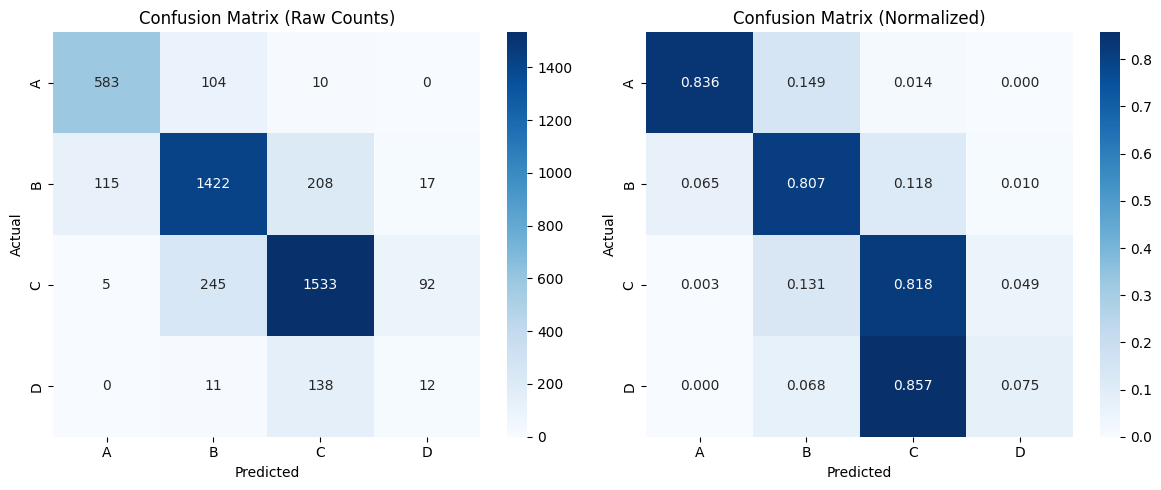

=== CONFUSION MATRIX ANALYSIS ===
Raw Confusion Matrix:
     A     B     C   D
A  583   104    10   0
B  115  1422   208  17
C    5   245  1533  92
D    0    11   138  12

Normalized Confusion Matrix:
       A      B      C      D
A  0.836  0.149  0.014  0.000
B  0.065  0.807  0.118  0.010
C  0.003  0.131  0.818  0.049
D  0.000  0.068  0.857  0.075


In [ ]:
# Create confusion matrix
plt.figure(figsize=(12, 5))

# Confusion Matrix - Raw Counts
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Raw Counts)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Confusion Matrix - Normalized
plt.subplot(1, 2, 2)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Print confusion matrix statistics
print("=== CONFUSION MATRIX ANALYSIS ===")
print("Raw Confusion Matrix:")
print(pd.DataFrame(cm, index=labels, columns=labels))
print("\nNormalized Confusion Matrix:")
print(pd.DataFrame(cm_norm.round(3), index=labels, columns=labels))

**9**

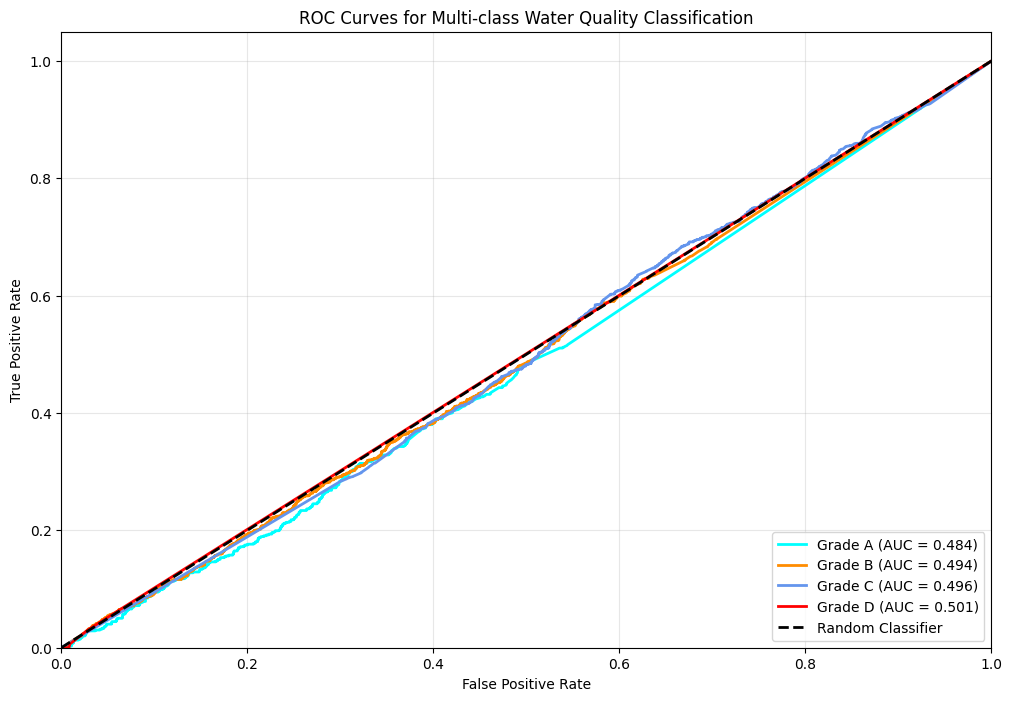

=== ROC AUC SCORES ===
Grade A: 0.4838
Grade B: 0.4935
Grade C: 0.4957
Grade D: 0.5009


In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the labels for multi-class ROC
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

# Calculate ROC curves for each class
plt.figure(figsize=(12, 8))

# Colors for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

for i, (class_name, color) in enumerate(zip(classes, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, linewidth=2,
             label=f'Grade {class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Water Quality Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and print AUC scores
print("=== ROC AUC SCORES ===")
for i, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"Grade {class_name}: {roc_auc:.4f}")

**10BBBBBBBBBBBBBBBBBBB**

**11**

**12**

**13**

**14**

**15**

**16**